In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from math import sqrt
from scipy import signal
from datetime import datetime
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
rng = np.random.default_rng()

In [2]:
medical=pd.read_csv("medical_time_series .csv")
medical.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [3]:
#convert to date format
medical['Day']=(pd.date_range(start=datetime(1970,1,1), periods=medical.shape[0], freq='24H'))
medical.set_index('Day', inplace=True)
medical

,Revenue
Day,
1970-01-01,0.000000
1970-01-02,-0.292356
1970-01-03,-0.327772
1970-01-04,-0.339987
1970-01-05,-0.124888
...,...
1971-12-28,15.722056
1971-12-29,15.865822
1971-12-30,15.708988


In [4]:
print(medical.isnull().sum())
print(medical.duplicated())

Revenue    0
dtype: int64
Day
1970-01-01    False
1970-01-02    False
1970-01-03    False
1970-01-04    False
1970-01-05    False
              ...  
1971-12-28    False
1971-12-29    False
1971-12-30    False
1971-12-31    False
1972-01-01    False
Length: 731, dtype: bool


In [5]:
#check for stationary ADF
result=adfuller(medical['Revenue'])
print("test stats: ", result[0])
print("p-value: ", result[1])
print("num of lags: ", result[2])
print("num of obs used for adf regression and critical values calc: ", result[3])
print("critical values: ", result[4])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")


test stats:  -2.2183190476089454
p-value:  0.19966400615064356
num of lags:  1
num of obs used for adf regression and critical values calc:  729
critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Fail to reject the null hypothesis (H0): The time series is non-stationary.


In [6]:
#difference data
medical['stationary']=medical['Revenue'].diff()
medical=medical.dropna()
medical.to_csv("stationary_dataset.csv")
medical

,Revenue,stationary
Day,,
1970-01-02,-0.292356,-0.292356
1970-01-03,-0.327772,-0.035416
1970-01-04,-0.339987,-0.012215
1970-01-05,-0.124888,0.215100
1970-01-06,-0.491590,-0.366702
...,...,...
1971-12-28,15.722056,-0.032693
1971-12-29,15.865822,0.143766
1971-12-30,15.708988,-0.156834


In [7]:
#check for stationary ADF
result=adfuller(medical['stationary'])
print("test stats: ", result[0])
print("p-value: ", result[1])
print("num of lags: ", result[2])
print("num of obs used for adf regression and critical values calc: ", result[3])
print("critical values: ", result[4])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")


test stats:  -17.374772303557062
p-value:  5.113206978840171e-30
num of lags:  0
num of obs used for adf regression and critical values calc:  729
critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject the null hypothesis (H0): The time series is stationary.


In [8]:
medical.tail()

,Revenue,stationary
Day,,
1971-12-28,15.722056,-0.032693
1971-12-29,15.865822,0.143766
1971-12-30,15.708988,-0.156834
1971-12-31,15.822867,0.113880
1972-01-01,16.069429,0.246562


In [9]:
#split the data into training and test
train_size=int(len(medical)*0.8)
train, test=medical.iloc[:train_size],medical.iloc[train_size:]
print(train.shape)
print(test.shape)

train.to_csv("train_d213.csv")
test.to_csv("test_d213.csv")

(584, 2)
(146, 2)


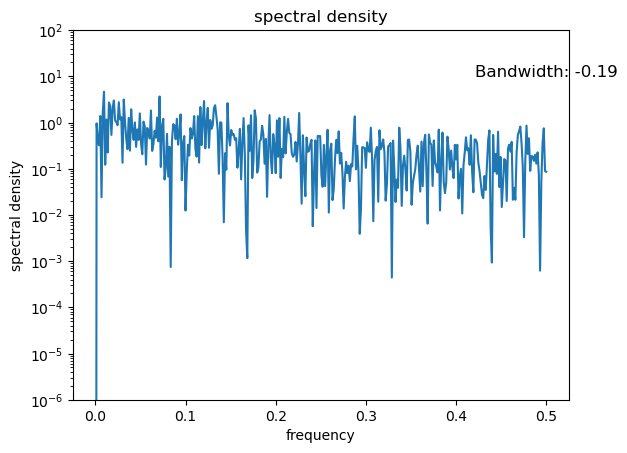

In [10]:
#spectral density
f, Pxx_den= signal.periodogram(medical['stationary'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6,1e2])
plt.title('spectral density')
plt.xlabel('frequency')
plt.ylabel('spectral density')
bw=np.trapz(f, Pxx_den)
plt.text(0.5, 10, f'Bandwidth: {bw:.2f}', fontsize=12, ha='center')
plt.show()

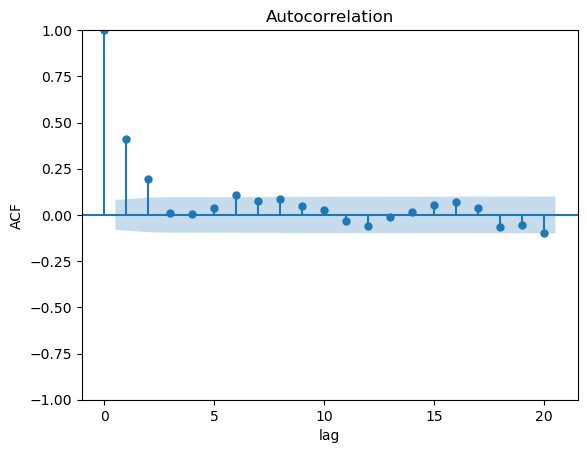

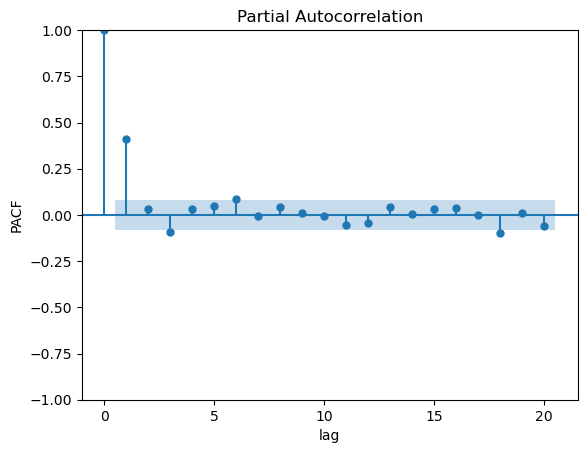

In [11]:
#perform acf and pacf
plot_acf(train['stationary'],lags=20)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()

plot_pacf(train['stationary'],lags=20)
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

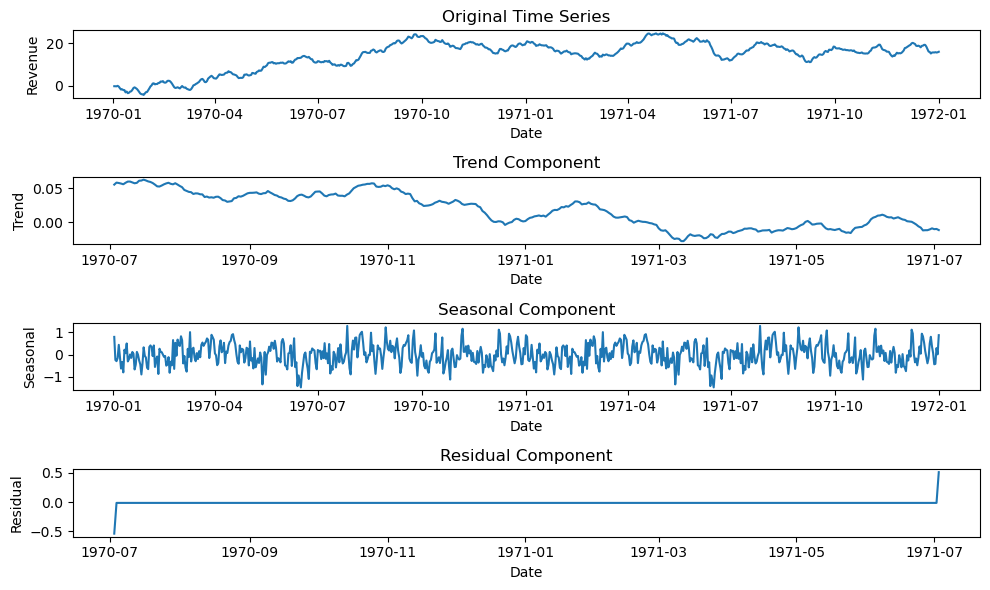

In [51]:


# Assuming 'medical' is your DataFrame containing the time series data

# Perform seasonal decomposition
decomp = seasonal_decompose(medical['stationary'], period=365)

# Extract trend, seasonal, and residual components
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the decomposition
plt.figure(figsize=(10, 6))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(medical['Revenue'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Revenue')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(residual)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()


<Axes: title={'center': 'trend'}, xlabel='Day', ylabel='revenue'>

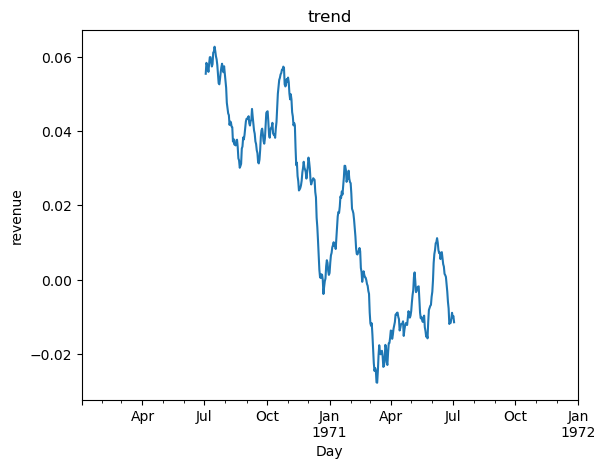

In [52]:
plt.title('trend')
plt.ylabel('revenue')
decomp.trend.plot()

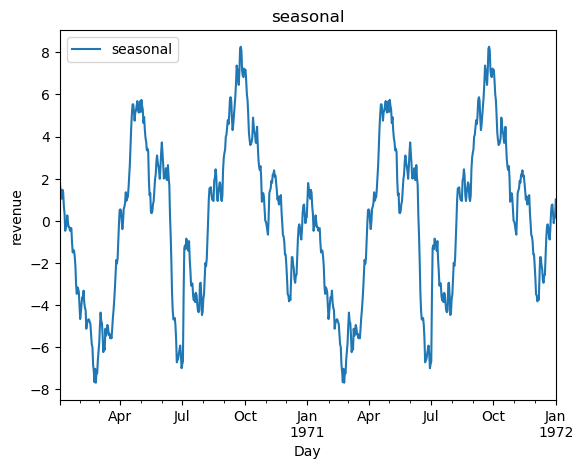

In [14]:
plt.title('seasonal')
plt.ylabel('revenue')
decomp.seasonal.plot()
plt.legend(loc='upper left')

<Axes: title={'center': 'residual'}, xlabel='Day', ylabel='revenue'>

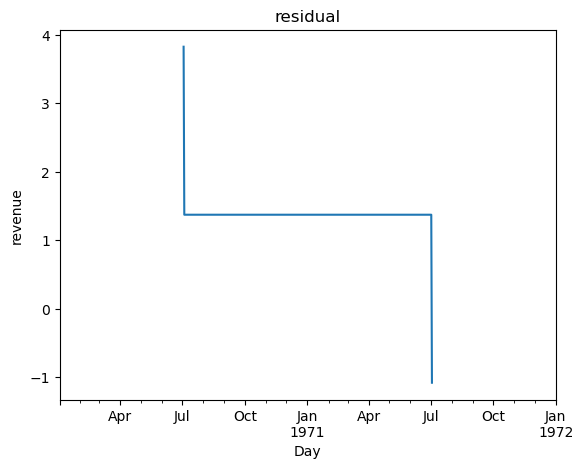

In [15]:
plt.title('residual')
plt.ylabel('revenue')
decomp.resid.plot()

In [16]:
warnings.filterwarnings("ignore")
stepwise_fit=auto_arima(medical['Revenue'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=882.726, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.163, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.725, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=905.489, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1014.728, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=882.666, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=882.679, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=882.775, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.385, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.314, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.330, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=904.505, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.407, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.693
Date:                Tue, 26 Mar 2024   AIC                            879.385
Time:                        12:28:32   BIC                            888.568
Sample:                    01-02-1970   HQIC                           882.928
                         - 01-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.246      0.000       0.348       0.480
sigma2         0.1945      0.011     17.824      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#ARIMA
model=ARIMA(train['Revenue'], order=(1,1,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.615
Date:                Tue, 26 Mar 2024   AIC                            705.230
Time:                        12:28:34   BIC                            713.966
Sample:                    01-02-1970   HQIC                           708.635
                         - 08-08-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.844      0.000       0.336       0.485
sigma2         0.1949      0.012     15.904      0.000       0.171       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.70   Prob(JB):                         0.40
Heteroskedasticity (H):               1.02   Skew:                            -0.05
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

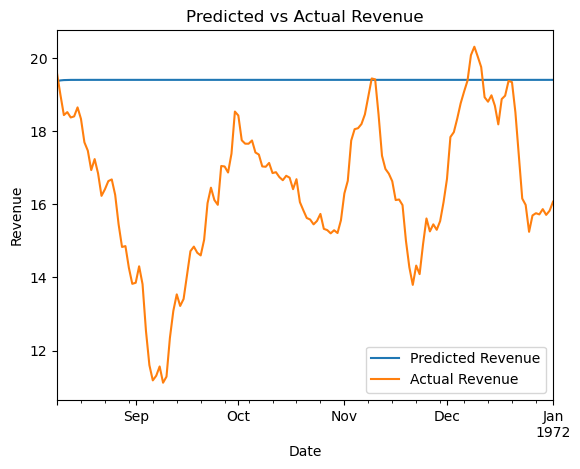

In [18]:
# Predict with test set
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ='levels')
pred.index = medical.index[start:end+1]
pred.plot(legend=True, label='Predicted Revenue')
test['Revenue'].plot(legend=True, label='Actual Revenue')

# Annotated Findings
plt.title('Predicted vs Actual Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [19]:
test['Revenue'].mean()

16.414766720547945

In [20]:
#rmse
rmse=sqrt(mean_squared_error(pred, test['Revenue']))
rmse

3.5918154361499384

In [21]:
#fit the model
model2=ARIMA(medical['Revenue'],order=(1,1,0))
model2=model2.fit()


In [22]:
#model prediction
future=pd.date_range(start='1972-01-02', end='1973-01-01')
future

DatetimeIndex(['1972-01-02', '1972-01-03', '1972-01-04', '1972-01-05',
               '1972-01-06', '1972-01-07', '1972-01-08', '1972-01-09',
               '1972-01-10', '1972-01-11',
               ...
               '1972-12-23', '1972-12-24', '1972-12-25', '1972-12-26',
               '1972-12-27', '1972-12-28', '1972-12-29', '1972-12-30',
               '1972-12-31', '1973-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')

In [31]:
prediction=model.predict(start=len(medical),end=len(medical)+365, typ='levels').rename('arima prediction')
prediction.index=future
prediction

1972-01-02    19.400948
1972-01-03    19.400948
1972-01-04    19.400948
1972-01-05    19.400948
1972-01-06    19.400948
                ...    
1972-12-28    19.400948
1972-12-29    19.400948
1972-12-30    19.400948
1972-12-31    19.400948
1973-01-01    19.400948
Freq: D, Name: arima prediction, Length: 366, dtype: float64

<Axes: >

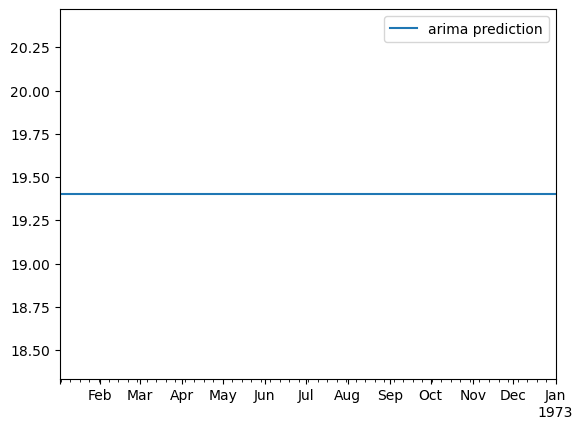

In [32]:
#prediction of revenue for next 365 days
prediction.plot(legend=True)

In [33]:
# Perform forecast using the derived ARIMA model
forecast_steps = 365
forecast= model2.forecast(steps=forecast_steps)

# Print the forecasted values
print(forecast)


1972-01-02    16.171544
1972-01-03    16.213835
1972-01-04    16.231351
1972-01-05    16.238605
1972-01-06    16.241609
                ...    
1972-12-27    16.243733
1972-12-28    16.243733
1972-12-29    16.243733
1972-12-30    16.243733
1972-12-31    16.243733
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


<Axes: title={'center': 'Residuals'}, xlabel='Day'>

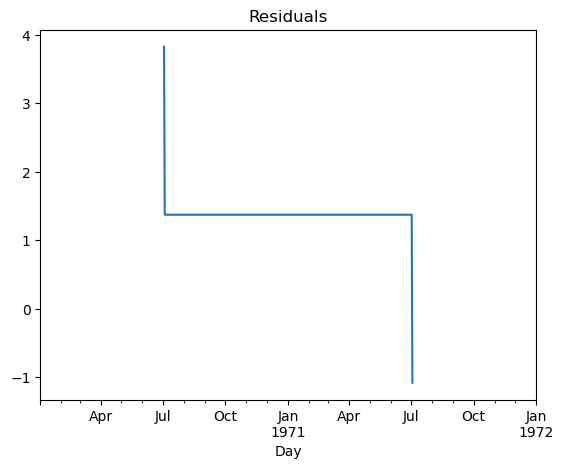

In [34]:
plt.title('Residuals')
decomp.resid.plot()

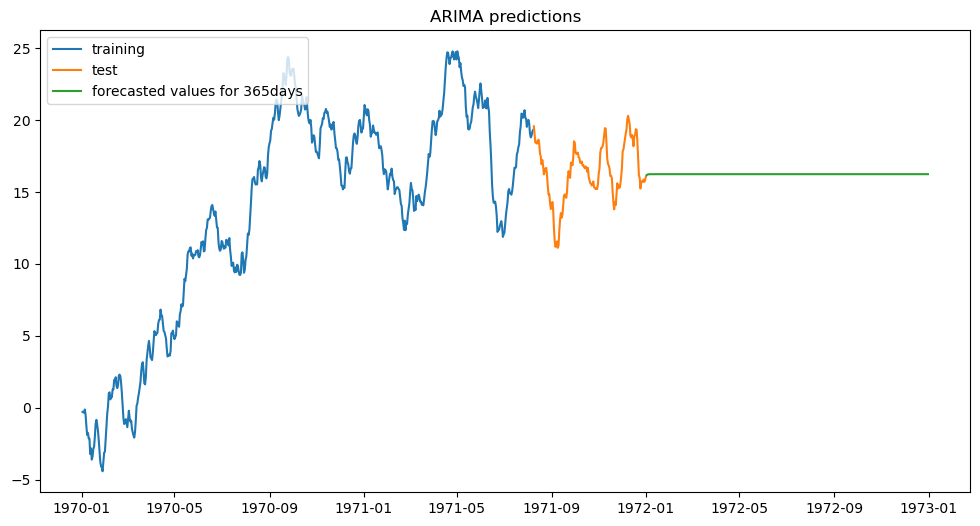

In [35]:
plt.figure(figsize=(12,6))
plt.plot(train['Revenue'],label='training')
plt.plot(test['Revenue'],label='test')
plt.plot(forecast,label='forecasted values for 365days')
plt.legend(loc='upper left')
plt.title('ARIMA predictions')
plt.show()


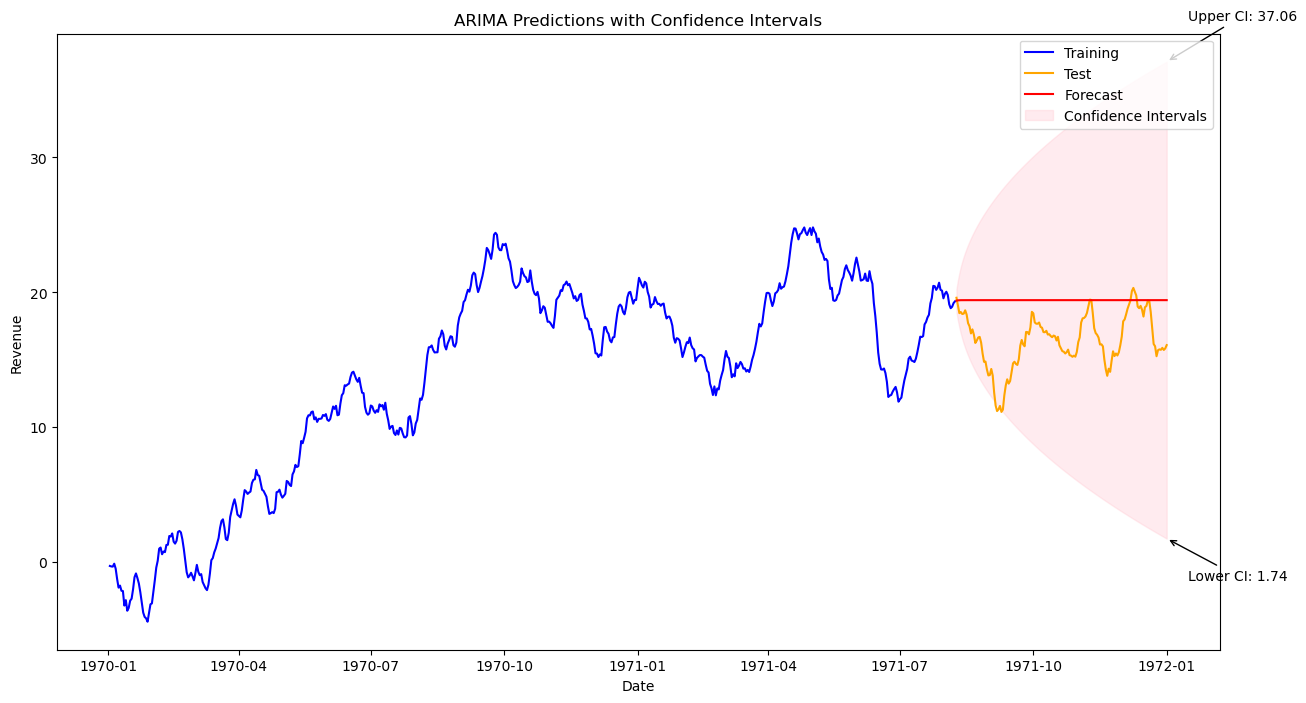

In [58]:

pred = model.get_prediction(start=test.index[0], end=test.index[-1])
pred_mean = pred.predicted_mean
pred_conf_int = pred.conf_int()


plt.figure(figsize=(15, 8))
plt.plot(train['Revenue'], label='Training', color='blue')  # Training data in blue
plt.plot(test['Revenue'], label='Test', color='orange')  # Test data in orange
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')  # Forecast in red

# Plot the confidence intervals
plt.fill_between(pred_mean.index, 
                 pred_conf_int.iloc[:, 0], 
                 pred_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Intervals')

# Annotate 
plt.annotate(f'Lower CI: {pred_conf_int.iloc[-1, 0]:.2f}', 
             xy=(pred_mean.index[-1], pred_conf_int.iloc[-1, 0]), 
             xytext=(15, -30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate(f'Upper CI: {pred_conf_int.iloc[-1, 1]:.2f}', 
             xy=(pred_mean.index[-1], pred_conf_int.iloc[-1, 1]), 
             xytext=(15, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('ARIMA Predictions with Confidence Intervals')
plt.legend()
plt.show()
